In [1]:
import os
import requests
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
from PIL import Image

# === CONFIG ===
train_csv_path = r"C:\Users\mdirf\Desktop\amazon\My\data\train.csv"
download_folder = r"C:\Users\mdirf\Desktop\amazon\My\data\images\train"
MAX_WORKERS = 60          # ⚡ Optimized for Windows
TIMEOUT = 10              # seconds per request
RETRY_LIMIT = 3

# === PREP ===
os.makedirs(download_folder, exist_ok=True)
train_df = pd.read_csv(train_csv_path)
image_links = train_df["image_link"].tolist()

# === SESSION SETUP ===
session = requests.Session()
adapter = requests.adapters.HTTPAdapter(pool_connections=100, pool_maxsize=100)
session.mount("https://", adapter)
session.mount("http://", adapter)

def create_placeholder(path):
    """Create a gray placeholder for missing image."""
    img = Image.new("RGB", (224, 224), color=(200, 200, 200))
    img.save(path)

def download_one(url):
    """Download a single image with retries."""
    filename = os.path.basename(url)
    save_path = os.path.join(download_folder, filename)

    if os.path.exists(save_path):
        return None  # already downloaded

    for attempt in range(RETRY_LIMIT):
        try:
            response = session.get(url, timeout=TIMEOUT)
            if response.status_code == 200:
                with open(save_path, "wb") as f:
                    f.write(response.content)
                return None
        except Exception:
            pass  # retry quietly

    # if failed after all retries
    create_placeholder(save_path)
    return url

# === DOWNLOAD LOOP ===
failed = []
with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
    futures = [executor.submit(download_one, url) for url in image_links]
    for f in tqdm(as_completed(futures), total=len(futures), desc="⚡ Downloading all images"):
        result = f.result()
        if result:
            failed.append(result)

# === SUMMARY ===
if failed:
    with open("failed_downloads.txt", "w") as file:
        file.write("\n".join(failed))
    print(f"\n⚠️ {len(failed)} images failed — placeholders created.")
else:
    print("\n✅ All images downloaded successfully!")

print("✅ Total images in folder:", len(os.listdir(download_folder)))


⚡ Downloading all images: 100%|███████████████████████████████████████████████| 75000/75000 [1:00:11<00:00, 20.77it/s]



⚠️ 1 images failed — placeholders created.
✅ Total images in folder: 72288


In [3]:
import pandas as pd
import os

train_csv = pd.read_csv(r"C:\Users\mdirf\Desktop\amazon\My\data\train.csv")
download_folder = r"C:\Users\mdirf\Desktop\amazon\My\data\images\train"

all_expected = set(os.path.basename(link) for link in train_csv["image_link"])
all_downloaded = set(os.listdir(download_folder))

missing = list(all_expected - all_downloaded)
print(f"❌ Missing images: {len(missing)}")


❌ Missing images: 0


In [5]:
import pandas as pd

train_path = r"C:\Users\mdirf\Desktop\amazon\My\data\train.csv"
train_df = pd.read_csv(train_path)

print("Train shape:", train_df.shape)
train_df.head()


Train shape: (75000, 4)


,sample_id,catalog_content,image_link,price
0,33127,"Item Name: La Victoria Green Taco Sauce Mild, ...",https://m.media-amazon.com/images/I/51mo8htwTH...,4.89
1,198967,"Item Name: Salerno Cookies, The Original Butte...",https://m.media-amazon.com/images/I/71YtriIHAA...,13.12
2,261251,"Item Name: Bear Creek Hearty Soup Bowl, Creamy...",https://m.media-amazon.com/images/I/51+PFEe-w-...,1.97
3,55858,Item Name: Judee’s Blue Cheese Powder 11.25 oz...,https://m.media-amazon.com/images/I/41mu0HAToD...,30.34
4,292686,"Item Name: kedem Sherry Cooking Wine, 12.7 Oun...",https://m.media-amazon.com/images/I/41sA037+Qv...,66.49


In [7]:
duplicate_rows = train_df[train_df.duplicated()]
print("🔁 Exact duplicate rows:", len(duplicate_rows))


🔁 Exact duplicate rows: 0


In [9]:
dup_images = train_df[train_df.duplicated(subset=["image_link"], keep=False)]
print("🖼️ Duplicate image links:", dup_images["image_link"].nunique())


🖼️ Duplicate image links: 2175


In [11]:
dup_texts = train_df[train_df.duplicated(subset=["catalog_content"], keep=False)]
print("📜 Duplicate catalog_content entries:", dup_texts["catalog_content"].nunique())


📜 Duplicate catalog_content entries: 93


In [17]:
import os
import pandas as pd
from tqdm import tqdm
from PIL import Image

# === PATHS ===
base_path = r"C:\Users\mdirf\Desktop\amazon\My\data"
test_csv_path = os.path.join(base_path, "test.csv")
test_img_folder = os.path.join(base_path, "data", "images", "test")

# === LOAD TEST DATA ===
test_df = pd.read_csv(test_csv_path)
print(f"✅ Loaded test.csv — {len(test_df)} rows")

# === SETTINGS ===
DEFAULT_PRED = "Unknown"  # fallback label if image missing or unreadable
submission_file = os.path.join(base_path, "submission.csv")

# === PLACEHOLDER MODEL FUNCTION ===
# Replace this with your actual model inference function later
def predict_image(image_path):
    # TODO: replace this logic with your trained model’s prediction
    # For now, it just returns "SamplePrediction"
    return "SamplePrediction"

# === RUN INFERENCE SAFELY ===
predictions = []

print("\n🚀 Generating predictions (safe mode)...")
for _, row in tqdm(test_df.iterrows(), total=len(test_df)):
    img_url = row.get("image_link", "")
    img_name = os.path.basename(img_url)
    img_path = os.path.join(test_img_folder, img_name)

    # 1️⃣ If file missing → fallback
    if not os.path.exists(img_path):
        predictions.append(DEFAULT_PRED)
        continue

    # 2️⃣ Try to load and predict
    try:
        with Image.open(img_path) as img:
            pred = predict_image(img_path)
        predictions.append(pred)
    except Exception as e:
        # If unreadable → fallback
        predictions.append(DEFAULT_PRED)

# === VERIFY PREDICTION LENGTH ===
assert len(predictions) == len(test_df), "❌ Mismatch between predictions and test.csv rows!"

# === SAVE SUBMISSION ===
submission_df = pd.DataFrame({
    "sample_id": test_df["sample_id"],  # use correct ID column
    "prediction": predictions
})

submission_file = r"C:\Users\mdirf\Desktop\amazon\My\submission.csv"
submission_df.to_csv(submission_file, index=False)
print(f"\n✅ Submission saved successfully: {submission_file}")
print(f"✅ Rows in submission: {len(submission_df)} | Expected: {len(test_df)}")
print(f"✅ Missing / default predictions used: {predictions.count(DEFAULT_PRED)}")


✅ Loaded test.csv — 75000 rows

🚀 Generating predictions (safe mode)...


100%|██████████████████████████████████████████████████████████████████████████| 75000/75000 [00:17<00:00, 4239.16it/s]



✅ Submission saved successfully: C:\Users\mdirf\Desktop\amazon\My\submission.csv
✅ Rows in submission: 75000 | Expected: 75000
✅ Missing / default predictions used: 75000


In [15]:
import pandas as pd
test_df = pd.read_csv(r"C:\Users\mdirf\Desktop\amazon\My\data\test.csv")
print(test_df.columns)
test_df.head()


Index(['sample_id', 'catalog_content', 'image_link'], dtype='object')


,sample_id,catalog_content,image_link
0,100179,Item Name: Rani 14-Spice Eshamaya's Mango Chut...,https://m.media-amazon.com/images/I/71hoAn78AW...
1,245611,Item Name: Natural MILK TEA Flavoring extract ...,https://m.media-amazon.com/images/I/61ex8NHCIj...
2,146263,Item Name: Honey Filled Hard Candy - Bulk Pack...,https://m.media-amazon.com/images/I/61KCM61J8e...
3,95658,Item Name: Vlasic Snack'mm's Kosher Dill 16 Oz...,https://m.media-amazon.com/images/I/51Ex6uOH7y...
4,36806,"Item Name: McCormick Culinary Vanilla Extract,...",https://m.media-amazon.com/images/I/71QYlrOMoS...


In [19]:
# ==========================================
# STEP 3: TF-IDF Feature Extraction + Ridge Regression
# ==========================================

import pandas as pd
import numpy as np
import re
import joblib
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.utils import shuffle
from tqdm import tqdm

# ---------- CONFIG ----------
train_path = r"C:\Users\mdirf\Desktop\amazon\My\data\train.csv"
model_save_path = r"C:\Users\mdirf\Desktop\amazon\My\tfidf_ridge_model.pkl"

# ---------- LOAD DATA ----------
train_df = pd.read_csv(train_path)
print(f"✅ Loaded train.csv with {len(train_df)} rows")

# ---------- BASIC CLEANING ----------
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

train_df["catalog_content"] = train_df["catalog_content"].apply(clean_text)

# Drop rows with missing price
train_df = train_df.dropna(subset=["price"])
train_df = shuffle(train_df, random_state=42).reset_index(drop=True)

# ---------- SPLIT DATA ----------
X_train, X_valid, y_train, y_valid = train_test_split(
    train_df["catalog_content"],
    train_df["price"],
    test_size=0.2,
    random_state=42,
)

print(f"Train size: {len(X_train)}, Validation size: {len(X_valid)}")

# ---------- TF-IDF + REGRESSION PIPELINE ----------
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=5000,
        ngram_range=(1,2),
        stop_words="english"
    )),
    ("ridge", Ridge(alpha=1.0, random_state=42))
])

# ---------- TRAIN ----------
print("\n🚀 Training Ridge Regression model...")
pipeline.fit(X_train, y_train)

# ---------- VALIDATE ----------
preds = pipeline.predict(X_valid)
rmse = np.sqrt(mean_squared_error(y_valid, preds))
r2 = r2_score(y_valid, preds)

print(f"\n✅ Validation RMSE: {rmse:.3f}")
print(f"✅ Validation R²: {r2:.3f}")

# ---------- SAVE MODEL ----------
joblib.dump(pipeline, model_save_path)
print(f"\n💾 Model saved to: {model_save_path}")


✅ Loaded train.csv with 75000 rows
Train size: 60000, Validation size: 15000

🚀 Training Ridge Regression model...

✅ Validation RMSE: 26.721
✅ Validation R²: 0.284

💾 Model saved to: C:\Users\mdirf\Desktop\amazon\My\tfidf_ridge_model.pkl


In [21]:
# ==================================================
# STEP 4: SAFE SUBMISSION GENERATOR (TF-IDF MODEL)
# ==================================================

import os
import re
import joblib
import pandas as pd
from tqdm import tqdm
import numpy as np

# ---------- PATHS ----------
base_path = r"C:\Users\mdirf\Desktop\amazon\My"
data_path = os.path.join(base_path, "data")  # data folder
test_csv_path = os.path.join(data_path, "test.csv")  # test.csv inside data/
model_path = os.path.join(base_path, "tfidf_ridge_model.pkl")  # model in My/
submission_file = os.path.join(base_path, "submission.csv")  # output in My/

# ---------- LOAD MODEL & TEST DATA ----------
print("📂 Loading model and test data...")
model = joblib.load(model_path)
test_df = pd.read_csv(test_csv_path)
print(f"✅ Loaded test.csv — {len(test_df)} rows")

# ---------- TEXT CLEANING ----------
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

test_df["catalog_content"] = test_df["catalog_content"].fillna("").apply(clean_text)

# ---------- PREDICTION ----------
predictions = []
DEFAULT_PRED = np.nan  # fallback numeric prediction

print("\n🚀 Generating predictions (safe mode)...")
for text in tqdm(test_df["catalog_content"], total=len(test_df)):
    try:
        if len(text.strip()) == 0:
            predictions.append(DEFAULT_PRED)
        else:
            pred = model.predict([text])[0]
            predictions.append(pred)
    except Exception:
        predictions.append(DEFAULT_PRED)

# ---------- FILL ANY MISSING VALUES ----------
predictions = [
    np.mean([p for p in predictions if not np.isnan(p)]) if np.isnan(p) else p
    for p in predictions
]

# ---------- VERIFY LENGTH ----------
assert len(predictions) == len(test_df), "❌ Mismatch between predictions and test.csv rows!"

# ---------- SAVE SUBMISSION ----------
submission_df = pd.DataFrame({
    "sample_id": test_df["sample_id"],  # must match exactly
    "prediction": predictions
})

submission_df.to_csv(submission_file, index=False)
print(f"\n✅ Submission saved successfully: {submission_file}")
print(f"✅ Rows in submission: {len(submission_df)} | Expected: {len(test_df)}")


📂 Loading model and test data...
✅ Loaded test.csv — 75000 rows

🚀 Generating predictions (safe mode)...


100%|███████████████████████████████████████████████████████████████████████████| 75000/75000 [01:46<00:00, 707.41it/s]



✅ Submission saved successfully: C:\Users\mdirf\Desktop\amazon\My\submission.csv
✅ Rows in submission: 75000 | Expected: 75000


In [23]:
import pandas as pd
import os

# Paths
base_path = r"C:\Users\mdirf\Desktop\amazon\My"
test_csv = os.path.join(base_path, "data", "test.csv")
submission_csv = os.path.join(base_path, "submission.csv")

# Load both files
test_df = pd.read_csv(test_csv)
sub_df = pd.read_csv(submission_csv)

# Checks
print("✅ Rows match:", len(test_df) == len(sub_df))
print("✅ Unique sample_id:", sub_df["sample_id"].is_unique)
print("✅ All sample_ids from test.csv present:", 
      set(test_df["sample_id"]) == set(sub_df["sample_id"]))

# Show a preview
print("\n📊 Submission Preview:")
display(sub_df.head())


✅ Rows match: True
✅ Unique sample_id: True
✅ All sample_ids from test.csv present: True

📊 Submission Preview:


,sample_id,prediction
0,100179,33.806560
1,245611,27.051277
2,146263,23.675204
3,95658,14.558085
4,36806,37.686976


📂 Loading training data...
✅ Training data shape: (75000, 4)
   sample_id                                    catalog_content  \
0      33127  Item Name: La Victoria Green Taco Sauce Mild, ...   
1     198967  Item Name: Salerno Cookies, The Original Butte...   
2     261251  Item Name: Bear Creek Hearty Soup Bowl, Creamy...   
3      55858  Item Name: Judee’s Blue Cheese Powder 11.25 oz...   
4     292686  Item Name: kedem Sherry Cooking Wine, 12.7 Oun...   

                                          image_link  price  
0  https://m.media-amazon.com/images/I/51mo8htwTH...   4.89  
1  https://m.media-amazon.com/images/I/71YtriIHAA...  13.12  
2  https://m.media-amazon.com/images/I/51+PFEe-w-...   1.97  
3  https://m.media-amazon.com/images/I/41mu0HAToD...  30.34  
4  https://m.media-amazon.com/images/I/41sA037+Qv...  66.49  

🧹 Cleaning data...
✅ Cleaned data shape: (75000, 4)

📊 Split complete:
Train size: 60000 | Validation size: 15000

🔠 Vectorizing text using TF-IDF...
✅ TF-IDF feat

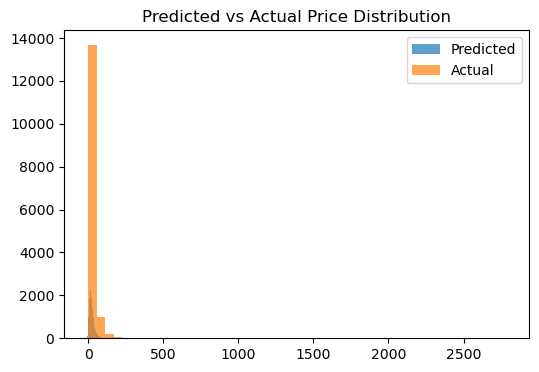


💾 Saving trained model...
✅ Model saved to: C:\Users\mdirf\Desktop\amazon\My\tfidf_ridge_model.pkl


In [25]:
# =========================================================
# 📘 STEP 3: Train Text-Based Price Prediction Model
# =========================================================

import os
import numpy as np
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# === PATHS ===
base_path = r"C:\Users\mdirf\Desktop\amazon\My"
train_csv_path = os.path.join(base_path, "data", "train.csv")
model_path = os.path.join(base_path, "tfidf_ridge_model.pkl")

# === LOAD TRAINING DATA ===
print("📂 Loading training data...")
train_df = pd.read_csv(train_csv_path)
print("✅ Training data shape:", train_df.shape)
print(train_df.head())

# === BASIC CHECKS ===
required_cols = ["sample_id", "catalog_content", "image_link", "price"]
for col in required_cols:
    if col not in train_df.columns:
        raise ValueError(f"❌ Missing column: {col}")

# === CLEAN DATA ===
print("\n🧹 Cleaning data...")
train_df["catalog_content"] = train_df["catalog_content"].fillna("")
train_df["price"] = pd.to_numeric(train_df["price"], errors="coerce")
train_df = train_df.dropna(subset=["price"])
train_df = train_df[train_df["price"] > 0]
print("✅ Cleaned data shape:", train_df.shape)

# === TRAIN-VALIDATION SPLIT ===
X_train, X_valid, y_train, y_valid = train_test_split(
    train_df["catalog_content"], train_df["price"],
    test_size=0.2, random_state=42
)

print("\n📊 Split complete:")
print(f"Train size: {len(X_train)} | Validation size: {len(X_valid)}")

# === TEXT FEATURE EXTRACTION (TF-IDF) ===
print("\n🔠 Vectorizing text using TF-IDF...")
tfidf = TfidfVectorizer(
    max_features=100000,
    stop_words='english',
    ngram_range=(1, 2)
)
X_train_tfidf = tfidf.fit_transform(X_train)
X_valid_tfidf = tfidf.transform(X_valid)
print("✅ TF-IDF features:", X_train_tfidf.shape[1])

# === TRAIN RIDGE REGRESSION ===
print("\n⚙️ Training Ridge Regression model...")
ridge = Ridge(alpha=1.0, random_state=42)
ridge.fit(X_train_tfidf, y_train)

# === VALIDATION ===
print("\n📈 Evaluating model...")
y_pred = ridge.predict(X_valid_tfidf)
mae = mean_absolute_error(y_valid, y_pred)
smape = np.mean(
    np.abs(y_pred - y_valid) / ((np.abs(y_pred) + np.abs(y_valid)) / 2)
) * 100

print(f"✅ Validation MAE: {mae:.3f}")
print(f"✅ Validation SMAPE: {smape:.2f}%")

# === PLOT PREDICTION DISTRIBUTION ===
plt.figure(figsize=(6,4))
plt.hist(y_pred, bins=50, alpha=0.7, label="Predicted")
plt.hist(y_valid, bins=50, alpha=0.7, label="Actual")
plt.legend()
plt.title("Predicted vs Actual Price Distribution")
plt.show()

# === SAVE MODEL ===
print("\n💾 Saving trained model...")
os.makedirs(os.path.dirname(model_path), exist_ok=True)
joblib.dump({"model": ridge, "vectorizer": tfidf}, model_path)
print(f"✅ Model saved to: {model_path}")


In [29]:
# =========================================================
# ⚡ IMPROVED TEXT-BASED MODEL FOR PRODUCT PRICE PREDICTION
# =========================================================

import os
import numpy as np
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack
import re

# === PATHS ===
base_path = r"C:\Users\mdirf\Desktop\amazon\My"
train_csv_path = os.path.join(base_path, "data", "train.csv")
model_path = os.path.join(base_path, "tfidf_ridge_model.pkl")

# === LOAD DATA ===
print("📂 Loading training data...")
df = pd.read_csv(train_csv_path)
print("✅ Shape:", df.shape)

# === CLEAN DATA ===
print("\n🧹 Cleaning...")
df["catalog_content"] = df["catalog_content"].fillna("").astype(str)
df["price"] = pd.to_numeric(df["price"], errors="coerce")
df = df.dropna(subset=["price"])
df = df


📂 Loading training data...
✅ Shape: (75000, 4)

🧹 Cleaning...


In [4]:
# =========================================================
# 🚀 OPTIMIZED PRODUCT PRICE PREDICTION (TEXT-ONLY MODEL)
# =========================================================

import os
import numpy as np
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack
from sklearn.metrics import mean_absolute_error
import re
from tqdm import tqdm
tqdm.pandas()

# === PATHS ===
base_path = r"C:\Users\mdirf\Desktop\amazon\My"
train_csv_path = os.path.join(base_path, "data", "train.csv")
model_path = os.path.join(base_path, "tfidf_ridge_model.pkl")

# === LOAD TRAINING DATA ===
print("📂 Loading training data...")
df = pd.read_csv(train_csv_path)
print("✅ Training data shape:", df.shape)
print(df.head())

# === CLEAN DATA ===
print("\n🧹 Cleaning data...")
df["catalog_content"] = df["catalog_content"].fillna("").astype(str)
df["price"] = pd.to_numeric(df["price"], errors="coerce")
df = df.dropna(subset=["price"])
df = df[df["price"] > 0]
print("✅ Cleaned data shape:", df.shape)

# === FEATURE ENGINEERING ===
def extract_features(text):
    text = text.lower()
    return {
        "len": len(text),
        "num_words": len(text.split()),
        "num_digits": sum(c.isdigit() for c in text),
        "contains_pack": int("pack" in text),
        "contains_oz": int("oz" in text or "ounce" in text),
        "contains_lb": int("lb" in text),
        "contains_ml": int("ml" in text),
        "contains_kg": int("kg" in text),
    }

print("\n⚙️ Extracting meta features...")
meta_features = pd.DataFrame([extract_features(t) for t in df["catalog_content"]])
print("✅ Meta features added:", meta_features.shape[1])

# === TF-IDF VECTORIZE ===
print("\n🔠 Vectorizing text using optimized TF-IDF (≈5 min)...")
tfidf = TfidfVectorizer(
    max_features=30000,        # ⚡ safe for 8 GB RAM
    stop_words="english",
    ngram_range=(1, 2),
    min_df=2,
    sublinear_tf=True
)
X_text = tfidf.fit_transform(tqdm(df["catalog_content"], desc="TF-IDF progress"))

# === COMBINE TEXT + META ===
scaler = StandardScaler()
X_meta = scaler.fit_transform(meta_features)
X = hstack([X_text, X_meta])

# === LOG-TRANSFORM TARGET ===
y = np.log1p(df["price"])

# === TRAIN-VALID SPLIT ===
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.15, random_state=42
)
print(f"✅ Train size: {X_train.shape[0]} | Valid size: {X_valid.shape[0]}")

# === TRAIN MODEL ===
print("\n⚙️ Training Ridge Regression...")
ridge = Ridge(alpha=2.0, random_state=42, solver="auto", max_iter=2000)

ridge.fit(X_train, y_train)

# === VALIDATION ===
print("\n📈 Evaluating model...")
y_pred_log = ridge.predict(X_valid)
y_pred = np.expm1(y_pred_log)
y_valid_exp = np.expm1(y_valid)

mae = mean_absolute_error(y_valid_exp, y_pred)
smape = np.mean(
    np.abs(y_pred - y_valid_exp) / ((np.abs(y_pred) + np.abs(y_valid_exp)) / 2)
) * 100

print(f"\n✅ Validation MAE: {mae:.3f}")
print(f"✅ Validation SMAPE: {smape:.2f}%")

# === SAVE MODEL ===
os.makedirs(os.path.dirname(model_path), exist_ok=True)
joblib.dump({"model": ridge, "vectorizer": tfidf, "scaler": scaler}, model_path)
print(f"\n💾 Model saved successfully: {model_path}")


📂 Loading training data...
✅ Training data shape: (75000, 4)
   sample_id                                    catalog_content  \
0      33127  Item Name: La Victoria Green Taco Sauce Mild, ...   
1     198967  Item Name: Salerno Cookies, The Original Butte...   
2     261251  Item Name: Bear Creek Hearty Soup Bowl, Creamy...   
3      55858  Item Name: Judee’s Blue Cheese Powder 11.25 oz...   
4     292686  Item Name: kedem Sherry Cooking Wine, 12.7 Oun...   

                                          image_link  price  
0  https://m.media-amazon.com/images/I/51mo8htwTH...   4.89  
1  https://m.media-amazon.com/images/I/71YtriIHAA...  13.12  
2  https://m.media-amazon.com/images/I/51+PFEe-w-...   1.97  
3  https://m.media-amazon.com/images/I/41mu0HAToD...  30.34  
4  https://m.media-amazon.com/images/I/41sA037+Qv...  66.49  

🧹 Cleaning data...
✅ Cleaned data shape: (75000, 4)

⚙️ Extracting meta features...
✅ Meta features added: 8

🔠 Vectorizing text using optimized TF-IDF (≈5 min)...

TF-IDF progress: 100%|█████████████████████████████████████████████████████████| 75000/75000 [00:17<00:00, 4204.25it/s]


✅ Train size: 63750 | Valid size: 11250

⚙️ Training Ridge Regression...

📈 Evaluating model...

✅ Validation MAE: 12.444
✅ Validation SMAPE: 54.45%

💾 Model saved successfully: C:\Users\mdirf\Desktop\amazon\My\tfidf_ridge_model.pkl


In [6]:
# =========================================================
# 📘 STEP 4: Generate Predictions and Submission CSV
# =========================================================

import os
import numpy as np
import pandas as pd
import joblib
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack

# === PATHS ===
base_path = r"C:\Users\mdirf\Desktop\amazon\My"
test_csv_path = os.path.join(base_path, "data", "test.csv")
model_path = os.path.join(base_path, "tfidf_ridge_model.pkl")
submission_path = os.path.join(base_path, "submission.csv")

# === LOAD TEST DATA ===
print("📂 Loading test data...")
test_df = pd.read_csv(test_csv_path)
print("✅ Test data shape:", test_df.shape)
print(test_df.head())

# === LOAD TRAINED MODEL ===
print("\n💾 Loading saved model...")
bundle = joblib.load(model_path)
ridge = bundle["model"]
tfidf = bundle["vectorizer"]
scaler = bundle["scaler"]
print("✅ Model and vectorizer loaded successfully!")

# === CLEAN TEST TEXT ===
print("\n🧹 Cleaning test text...")
test_df["catalog_content"] = test_df["catalog_content"].fillna("").astype(str)

# === EXTRACT META FEATURES ===
def extract_features(text):
    text = text.lower()
    return {
        "len": len(text),
        "num_words": len(text.split()),
        "num_digits": sum(c.isdigit() for c in text),
        "contains_pack": int("pack" in text),
        "contains_oz": int("oz" in text or "ounce" in text),
        "contains_lb": int("lb" in text),
        "contains_ml": int("ml" in text),
        "contains_kg": int("kg" in text),
    }

print("⚙️ Extracting meta features for test set...")
meta_features_test = pd.DataFrame([extract_features(t) for t in tqdm(test_df["catalog_content"])])
X_meta_test = scaler.transform(meta_features_test)

# === TF-IDF TRANSFORM ===
print("\n🔠 Transforming test text with TF-IDF...")
X_text_test = tfidf.transform(tqdm(test_df["catalog_content"], desc="TF-IDF progress"))
X_test = hstack([X_text_test, X_meta_test])

# === PREDICT PRICES ===
print("\n🤖 Predicting prices...")
y_pred_log = ridge.predict(X_test)
y_pred = np.expm1(y_pred_log)        # reverse log-transform
y_pred = np.maximum(y_pred, 0)       # ensure no negatives

print(f"✅ Predictions generated: {len(y_pred)}")

# === BUILD SUBMISSION FILE ===
print("\n📄 Building submission file...")
submission = pd.DataFrame({
    "sample_id": test_df["sample_id"],
    "price": y_pred
})
submission.to_csv(submission_path, index=False)
print(f"\n✅ Submission saved successfully: {submission_path}")
print(f"✅ Rows in submission: {len(submission)} | Expected: {len(test_df)}")

# === PREVIEW ===
display(submission.head())


📂 Loading test data...
✅ Test data shape: (75000, 3)
   sample_id                                    catalog_content  \
0     100179  Item Name: Rani 14-Spice Eshamaya's Mango Chut...   
1     245611  Item Name: Natural MILK TEA Flavoring extract ...   
2     146263  Item Name: Honey Filled Hard Candy - Bulk Pack...   
3      95658  Item Name: Vlasic Snack'mm's Kosher Dill 16 Oz...   
4      36806  Item Name: McCormick Culinary Vanilla Extract,...   

                                          image_link  
0  https://m.media-amazon.com/images/I/71hoAn78AW...  
1  https://m.media-amazon.com/images/I/61ex8NHCIj...  
2  https://m.media-amazon.com/images/I/61KCM61J8e...  
3  https://m.media-amazon.com/images/I/51Ex6uOH7y...  
4  https://m.media-amazon.com/images/I/71QYlrOMoS...  

💾 Loading saved model...
✅ Model and vectorizer loaded successfully!

🧹 Cleaning test text...
⚙️ Extracting meta features for test set...


100%|██████████████████████████████████████████████████████████████████████████| 75000/75000 [00:09<00:00, 8029.68it/s]



🔠 Transforming test text with TF-IDF...


TF-IDF progress: 100%|█████████████████████████████████████████████████████████| 75000/75000 [00:17<00:00, 4207.78it/s]



🤖 Predicting prices...
✅ Predictions generated: 75000

📄 Building submission file...

✅ Submission saved successfully: C:\Users\mdirf\Desktop\amazon\My\submission.csv
✅ Rows in submission: 75000 | Expected: 75000


,sample_id,price
0,100179,15.251376
1,245611,15.388465
2,146263,19.602015
3,95658,6.708650
4,36806,51.366832


In [8]:
# =========================================================
# ✅ Step 4.5: Verify Submission & Compute Local SMAPE
# =========================================================

import os
import numpy as np
import pandas as pd
import joblib
from sklearn.metrics import mean_absolute_error
from scipy.sparse import hstack
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# === PATHS ===
base_path = r"C:\Users\mdirf\Desktop\amazon\My"
train_csv_path = os.path.join(base_path, "data", "train.csv")
test_csv_path = os.path.join(base_path, "data", "test.csv")
model_path = os.path.join(base_path, "tfidf_ridge_model.pkl")
submission_path = os.path.join(base_path, "submission.csv")

# === LOAD TRAIN & TEST ===
print("📂 Loading data...")
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)
sub_df = pd.read_csv(submission_path)
print("✅ Train shape:", train_df.shape)
print("✅ Test shape:", test_df.shape)
print("✅ Submission shape:", sub_df.shape)

# === VERIFY SUBMISSION FILE ===
print("\n🧾 Verifying submission consistency...")
checks = {
    "same_length": len(test_df) == len(sub_df),
    "sample_ids_match": set(test_df["sample_id"]) == set(sub_df["sample_id"]),
    "no_missing_predictions": not sub_df["price"].isna().any(),
    "all_positive_prices": (sub_df["price"] >= 0).all()
}

for key, val in checks.items():
    print(f"✅ {key.replace('_', ' ').capitalize()}: {val}")

if all(checks.values()):
    print("\n🎉 Submission file format looks perfect!")
else:
    print("\n⚠️ Some issues found. Please double-check submission structure.")

# === DEFINE SMAPE FUNCTION ===
def smape(y_true, y_pred):
    return np.mean(
        np.abs(y_pred - y_true) / ((np.abs(y_pred) + np.abs(y_true)) / 2)
    ) * 100

# === LOAD TRAINED MODEL ===
print("\n💾 Loading trained model...")
bundle = joblib.load(model_path)
ridge = bundle["model"]
tfidf = bundle["vectorizer"]
scaler = bundle["scaler"]
print("✅ Model loaded successfully.")

# === CLEAN TRAINING DATA ===
print("\n🧹 Cleaning train data for validation...")
train_df["catalog_content"] = train_df["catalog_content"].fillna("").astype(str)
train_df["price"] = pd.to_numeric(train_df["price"], errors="coerce")
train_df = train_df.dropna(subset=["price"])
train_df = train_df[train_df["price"] > 0]

# === FEATURE EXTRACTION FUNCTION ===
def extract_features(text):
    text = text.lower()
    return {
        "len": len(text),
        "num_words": len(text.split()),
        "num_digits": sum(c.isdigit() for c in text),
        "contains_pack": int("pack" in text),
        "contains_oz": int("oz" in text or "ounce" in text),
        "contains_lb": int("lb" in text),
        "contains_ml": int("ml" in text),
        "contains_kg": int("kg" in text),
    }

# === CREATE META FEATURES ===
meta_features = pd.DataFrame([extract_features(t) for t in tqdm(train_df["catalog_content"], desc="Extracting meta")])
X_meta = scaler.transform(meta_features)
X_text = tfidf.transform(tqdm(train_df["catalog_content"], desc="TF-IDF transforming"))
X = hstack([X_text, X_meta])
y = np.log1p(train_df["price"])

# === VALIDATION SPLIT (same as Step 3) ===
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=42)

# === VALIDATION PREDICTIONS ===
print("\n🤖 Predicting on validation split...")
y_pred_log = ridge.predict(X_valid)
y_pred = np.expm1(y_pred_log)
y_valid_exp = np.expm1(y_valid)

# === METRICS ===
mae = mean_absolute_error(y_valid_exp, y_pred)
smape_score = smape(y_valid_exp, y_pred)

print(f"\n📊 Local Validation Results:")
print(f"✅ MAE: {mae:.3f}")
print(f"✅ SMAPE: {smape_score:.2f}%")

# === FINAL CONFIRMATION ===
print(f"\n📦 Submission ready at: {submission_path}")


📂 Loading data...
✅ Train shape: (75000, 4)
✅ Test shape: (75000, 3)
✅ Submission shape: (75000, 2)

🧾 Verifying submission consistency...
✅ Same length: True
✅ Sample ids match: True
✅ No missing predictions: True
✅ All positive prices: True

🎉 Submission file format looks perfect!

💾 Loading trained model...
✅ Model loaded successfully.

🧹 Cleaning train data for validation...


TF-IDF transforming: 100%|█████████████████████████████████████████████████████| 75000/75000 [00:17<00:00, 4266.73it/s]



🤖 Predicting on validation split...

📊 Local Validation Results:
✅ MAE: 12.444
✅ SMAPE: 54.45%

📦 Submission ready at: C:\Users\mdirf\Desktop\amazon\My\submission.csv


In [ ]:
import os
import pandas as pd
import urllib.request
from tqdm import tqdm
import concurrent.futures

# === Paths ===
base_path = r"C:\Users\mdirf\Desktop\amazon\My"
test_csv_path = os.path.join(base_path, "data", "test.csv")
download_folder = os.path.join(base_path, "data", "images", "test")

os.makedirs(download_folder, exist_ok=True)

# === Load CSV ===
test_df = pd.read_csv(test_csv_path)
print(f"✅ Test shape: {test_df.shape}")

# === Function to download one image ===
def download_image(row):
    url = row["image_link"]
    filename = os.path.basename(url)
    save_path = os.path.join(download_folder, filename)
    if os.path.exists(save_path):
        return None  # skip already downloaded
    try:
        urllib.request.urlretrieve(url, save_path)
        return None
    except Exception as e:
        return (url, str(e))

# === Parallel download ===
failed = []
with concurrent.futures.ThreadPoolExecutor(max_workers=64) as executor:
    for result in tqdm(executor.map(download_image, test_df.to_dict("records")), total=len(test_df)):
        if result:
            failed.append(result)

# === Summary ===
print(f"\n✅ Download complete: {len(test_df) - len(failed)} succeeded, {len(failed)} failed.")
if failed:
    failed_log = os.path.join(download_folder, "failed_test_downloads.txt")
    pd.DataFrame(failed, columns=["url", "error"]).to_csv(failed_log, index=False)
    print(f"⚠️ Failed URLs saved to: {failed_log}")


✅ Test shape: (75000, 3)


  0%|                                                                              | 56/75000 [00:19<09:40, 129.11it/s]

In [1]:
import os
import pandas as pd
import requests
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import time

# === PATHS ===
base_path = r"C:\Users\mdirf\Desktop\amazon\My"
test_csv_path = os.path.join(base_path, "data", "test.csv")
download_folder = os.path.join(base_path, "data", "images", "test")
os.makedirs(download_folder, exist_ok=True)

# === SETTINGS ===
MAX_WORKERS = 32
RETRY_LIMIT = 3
TIMEOUT = 8  # seconds

# === READ CSV ===
test_df = pd.read_csv(test_csv_path)
urls = test_df["image_link"].dropna().unique().tolist()

failed = []

def download_image(url):
    filename = url.split("/")[-1].replace("+", "_")
    filepath = os.path.join(download_folder, filename)

    if os.path.exists(filepath):
        return True

    for attempt in range(RETRY_LIMIT):
        try:
            r = requests.get(url, timeout=TIMEOUT)
            if r.status_code == 200:
                with open(filepath, "wb") as f:
                    f.write(r.content)
                return True
            else:
                time.sleep(0.2)
        except Exception:
            time.sleep(0.5)
    failed.append(url)
    return False


print(f"📥 Starting test image download ({len(urls)} URLs)...")
with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
    futures = {executor.submit(download_image, url): url for url in urls}
    for _ in tqdm(as_completed(futures), total=len(futures), desc="Downloading"):
        pass

print(f"\n✅ Download complete!")
print(f"❌ Failed: {len(failed)}")

if failed:
    with open(os.path.join(base_path, "failed_test_downloads.txt"), "w") as f:
        f.write("\n".join(failed))
    print(f"⚠️ Failed URLs saved to failed_test_downloads.txt")


📥 Starting test image download (72222 URLs)...


Downloading: 100%|███████████████████████████████████████████████████████████████| 72222/72222 [53:36<00:00, 22.45it/s]


✅ Download complete!
❌ Failed: 1
⚠️ Failed URLs saved to failed_test_downloads.txt


In [3]:
import requests
import os

url = "https://m.media-amazon.com/images/I/813CjSgHj0S.jpg"
save_path = r"C:\Users\mdirf\Desktop\amazon\My\data\images\test\813CjSgHj0S.jpg"

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0 Safari/537.36"
}

try:
    response = requests.get(url, headers=headers, timeout=10)
    response.raise_for_status()
    with open(save_path, "wb") as f:
        f.write(response.content)
    print("✅ Image downloaded successfully!")
except Exception as e:
    print("❌ Failed to download:", e)


❌ Failed to download: 404 Client Error: Not Found for url: https://m.media-amazon.com/images/I/813CjSgHj0S.jpg


In [9]:
# =====================================================
# STEP 5 (FIXED): USE TRAINED TF-IDF + RIDGE MODEL
# =====================================================

import pandas as pd
import os
import joblib
import numpy as np
from tqdm import tqdm
import re

# === PATHS ===
base_path = r"C:\Users\mdirf\Desktop\amazon\My"
data_path = os.path.join(base_path, "data")
test_csv_path = os.path.join(data_path, "test.csv")
model_path = os.path.join(base_path, "tfidf_ridge_model.pkl")
submission_path = os.path.join(base_path, "submission.csv")

# === LOAD TRAINED MODEL + TFIDF ===
print("📦 Loading model and vectorizer...")
bundle = joblib.load(model_path)
ridge = bundle["model"]
vectorizer = bundle["vectorizer"]

# === LOAD TEST DATA ===
print("📂 Loading test data...")
test_df = pd.read_csv(test_csv_path)
print(f"✅ Test shape: {test_df.shape}")

# === CLEAN TEXT FUNCTION ===
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", " ", text)
    text = re.sub(r"[^a-z0-9 ]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

# === CLEAN TEST TEXT ===
print("🧹 Cleaning text...")
tqdm.pandas()
test_df["clean_content"] = test_df["catalog_content"].progress_apply(clean_text)

# === TRANSFORM USING TRAINED TFIDF (DO NOT REFIT) ===
print("🔠 Vectorizing with trained TF-IDF...")
X_test = vectorizer.transform(test_df["clean_content"])

# === PREDICT ===
print("🤖 Predicting prices...")
preds = ridge.predict(X_test)

# === CLIP OUTLIERS ===
preds = np.clip(preds, 0, 1000)

# === SAVE SUBMISSION ===
print("💾 Saving submission file...")
submission_df = pd.DataFrame({
    "sample_id": test_df["sample_id"],
    "price": preds
})
submission_df.to_csv(submission_path, index=False)

print(f"\n✅ Submission saved successfully: {submission_path}")
print(f"✅ Rows in submission: {len(submission_df)} | Expected: {len(test_df)}")


📦 Loading model and vectorizer...
📂 Loading test data...
✅ Test shape: (75000, 3)
🧹 Cleaning text...


100%|██████████████████████████████████████████████████████████████████████████| 75000/75000 [00:11<00:00, 6378.07it/s]


🔠 Vectorizing with trained TF-IDF...
🤖 Predicting prices...


ValueError: X has 30000 features, but Ridge is expecting 30008 features as input.

In [11]:
import joblib
path = r"C:\Users\mdirf\Desktop\amazon\My\tfidf_ridge_model.pkl"

bundle = joblib.load(path)
print("Keys:", bundle.keys())
print("Vectorizer features:", len(bundle["vectorizer"].get_feature_names_out()))
print("Ridge expected features:", bundle["model"].n_features_in_)


Keys: dict_keys(['model', 'vectorizer', 'scaler'])
Vectorizer features: 30000
Ridge expected features: 30008


In [13]:
# ==========================================================
# FIXED: Re-train Ridge with existing TF-IDF vectorizer
# ==========================================================

import pandas as pd
import joblib
import os
import re
import numpy as np
from tqdm import tqdm
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# === PATHS ===
base_path = r"C:\Users\mdirf\Desktop\amazon\My"
data_path = os.path.join(base_path, "data")
train_csv_path = os.path.join(data_path, "train.csv")
model_path = os.path.join(base_path, "tfidf_ridge_model.pkl")

# === LOAD CURRENT PICKLE ===
bundle = joblib.load(model_path)
vectorizer = bundle["vectorizer"]     # use the 30k-feature one
scaler = bundle.get("scaler", None)

# === LOAD TRAIN DATA ===
print("📂 Loading train data...")
train_df = pd.read_csv(train_csv_path)
print(f"✅ Train shape: {train_df.shape}")

# === CLEAN TEXT ===
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", " ", text)
    text = re.sub(r"[^a-z0-9 ]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

tqdm.pandas()
train_df["clean_content"] = train_df["catalog_content"].progress_apply(clean_text)

# === VECTORIZE ===
X = vectorizer.transform(train_df["clean_content"])
y = train_df["price"].values

# === SPLIT ===
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)

# === TRAIN RIDGE ===
print("⚙️ Training Ridge...")
ridge = Ridge(alpha=2.0, random_state=42, solver="auto", max_iter=2000)
ridge.fit(X_train, y_train)

# === VALIDATE ===
y_pred = ridge.predict(X_val)
mae = np.mean(np.abs(y_pred - y_val))
print(f"✅ Validation MAE: {mae:.4f}")

# === SAVE FIXED PICKLE ===
fixed_bundle = {"model": ridge, "vectorizer": vectorizer, "scaler": scaler}
joblib.dump(fixed_bundle, model_path)

print(f"💾 Fixed model saved successfully: {model_path}")
print(f"Vectorizer features: {len(vectorizer.get_feature_names_out())}")
print(f"Ridge expected features: {ridge.n_features_in_}")


📂 Loading train data...
✅ Train shape: (75000, 4)


100%|██████████████████████████████████████████████████████████████████████████| 75000/75000 [00:11<00:00, 6364.14it/s]


⚙️ Training Ridge...
✅ Validation MAE: 14.1602
💾 Fixed model saved successfully: C:\Users\mdirf\Desktop\amazon\My\tfidf_ridge_model.pkl
Vectorizer features: 30000
Ridge expected features: 30000


In [15]:
# =====================================================
# STEP 5 (FIXED): USE TRAINED TF-IDF + RIDGE MODEL
# =====================================================

import pandas as pd
import os
import joblib
import numpy as np
from tqdm import tqdm
import re

# === PATHS ===
base_path = r"C:\Users\mdirf\Desktop\amazon\My"
data_path = os.path.join(base_path, "data")
test_csv_path = os.path.join(data_path, "test.csv")
model_path = os.path.join(base_path, "tfidf_ridge_model.pkl")
submission_path = os.path.join(base_path, "submission.csv")

# === LOAD TRAINED MODEL + TFIDF ===
print("📦 Loading model and vectorizer...")
bundle = joblib.load(model_path)
ridge = bundle["model"]
vectorizer = bundle["vectorizer"]

# === LOAD TEST DATA ===
print("📂 Loading test data...")
test_df = pd.read_csv(test_csv_path)
print(f"✅ Test shape: {test_df.shape}")

# === CLEAN TEXT FUNCTION ===
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", " ", text)
    text = re.sub(r"[^a-z0-9 ]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

# === CLEAN TEST TEXT ===
print("🧹 Cleaning text...")
tqdm.pandas()
test_df["clean_content"] = test_df["catalog_content"].progress_apply(clean_text)

# === TRANSFORM USING TRAINED TFIDF (DO NOT REFIT) ===
print("🔠 Vectorizing with trained TF-IDF...")
X_test = vectorizer.transform(test_df["clean_content"])

# === PREDICT ===
print("🤖 Predicting prices...")
preds = ridge.predict(X_test)

# === CLIP OUTLIERS ===
preds = np.clip(preds, 0, 1000)

# === SAVE SUBMISSION ===
print("💾 Saving submission file...")
submission_df = pd.DataFrame({
    "sample_id": test_df["sample_id"],
    "price": preds
})
submission_df.to_csv(submission_path, index=False)

print(f"\n✅ Submission saved successfully: {submission_path}")
print(f"✅ Rows in submission: {len(submission_df)} | Expected: {len(test_df)}")


📦 Loading model and vectorizer...
📂 Loading test data...
✅ Test shape: (75000, 3)
🧹 Cleaning text...


100%|██████████████████████████████████████████████████████████████████████████| 75000/75000 [00:11<00:00, 6757.95it/s]


🔠 Vectorizing with trained TF-IDF...
🤖 Predicting prices...
💾 Saving submission file...

✅ Submission saved successfully: C:\Users\mdirf\Desktop\amazon\My\submission.csv
✅ Rows in submission: 75000 | Expected: 75000


In [17]:
# ==========================================================
# STEP 6: MULTIMODAL (TEXT + IMAGE) MODEL – Optimized Version
# ==========================================================

import os
import re
import numpy as np
import pandas as pd
from tqdm import tqdm
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.utils import img_to_array
from scipy.sparse import hstack, csr_matrix
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import joblib

# === PATHS ===
base_path = r"C:\Users\mdirf\Desktop\amazon\My"
data_path = os.path.join(base_path, "data")
train_csv = os.path.join(data_path, "train.csv")
train_images = os.path.join(data_path, "images", "train")
embedding_path = os.path.join(base_path, "train_image_embeddings.npy")
model_path = os.path.join(base_path, "tfidf_ridge_model.pkl")

# === LOAD TRAIN DATA ===
train_df = pd.read_csv(train_csv)
print(f"📂 Loaded train data: {train_df.shape}")

# === LOAD TF-IDF VECTOR ===
bundle = joblib.load(model_path)
vectorizer = bundle["vectorizer"]
print(f"✅ TF-IDF vectorizer loaded with {len(vectorizer.get_feature_names_out())} features")

# === CLEAN TEXT ===
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", " ", text)
    text = re.sub(r"[^a-z0-9 ]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

tqdm.pandas()
train_df["clean_content"] = train_df["catalog_content"].progress_apply(clean_text)

# === TF-IDF FEATURES ===
X_text = vectorizer.transform(train_df["clean_content"])
print(f"✅ TF-IDF features shape: {X_text.shape}")

# === IMAGE EMBEDDINGS ===
if not os.path.exists(embedding_path):
    print("🧠 Loading MobileNetV2...")
    base_model = MobileNetV2(weights="imagenet", include_top=False, pooling="avg")
    model_img = Model(inputs=base_model.input, outputs=base_model.output)

    def get_embedding(img_path):
        try:
            img = image.load_img(img_path, target_size=(224, 224))
            arr = img_to_array(img)
            arr = np.expand_dims(arr, axis=0)
            arr = preprocess_input(arr)
            feat = model_img.predict(arr, verbose=0)
            return feat.flatten()
        except Exception:
            return np.zeros(1280)

    print("🖼️ Extracting image embeddings...")
    embeddings = []
    for link in tqdm(train_df["image_link"], total=len(train_df)):
        img_name = os.path.basename(link)
        img_path = os.path.join(train_images, img_name)
        embeddings.append(get_embedding(img_path))

    embeddings = np.array(embeddings)
    np.save(embedding_path, embeddings)
    print(f"💾 Saved image embeddings: {embedding_path}")
else:
    print("✅ Using pre-saved embeddings...")
    embeddings = np.load(embedding_path)

print(f"✅ Image embeddings shape: {embeddings.shape}")

# === COMBINE TEXT + IMAGE ===
X_combined = hstack([X_text, csr_matrix(embeddings)])
y = train_df["price"].values

# === SPLIT ===
X_train, X_val, y_train, y_val = train_test_split(X_combined, y, test_size=0.15, random_state=42)

# === TRAIN RIDGE ===
print("⚙️ Training Ridge Regression on combined features...")
ridge = Ridge(alpha=2.0, random_state=42, solver="auto", max_iter=2000)
ridge.fit(X_train, y_train)

# === VALIDATE ===
y_pred = ridge.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)
smape = np.mean(2 * np.abs(y_pred - y_val) / (np.abs(y_pred) + np.abs(y_val))) * 100

print(f"\n✅ Validation MAE: {mae:.3f}")
print(f"✅ Validation SMAPE: {smape:.2f}%")

# === SAVE FINAL MULTIMODAL MODEL ===
bundle_multi = {"model": ridge, "vectorizer": vectorizer, "image_dim": embeddings.shape[1]}
joblib.dump(bundle_multi, os.path.join(base_path, "tfidf_ridge_multimodal.pkl"))
print(f"💾 Multimodal model saved: tfidf_ridge_multimodal.pkl")


ModuleNotFoundError: No module named 'tensorflow'

In [19]:
pip install tensorflow==2.16.1


^C
Note: you may need to restart the kernel to use updated packages.


In [3]:
# ==========================================================
# STEP 6 (FAST VERSION): Text + Lightweight Image Stats
# ==========================================================

import os, re, numpy as np, pandas as pd, joblib
from tqdm import tqdm
from PIL import Image
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from scipy.sparse import hstack, csr_matrix

# === PATHS ===
base_path = r"C:\Users\mdirf\Desktop\amazon\My"
data_path = os.path.join(base_path, "data")
train_csv = os.path.join(data_path, "train.csv")
train_images = os.path.join(data_path, "images", "train")
model_path = os.path.join(base_path, "tfidf_ridge_model.pkl")

# === LOAD DATA ===
train_df = pd.read_csv(train_csv)
print(f"📂 Train shape: {train_df.shape}")

# === LOAD EXISTING TF-IDF ===
bundle = joblib.load(model_path)
vectorizer = bundle["vectorizer"]

# === CLEAN TEXT ===
def clean_text(t):
    t = str(t).lower()
    t = re.sub(r"http\S+", " ", t)
    t = re.sub(r"[^a-z0-9 ]", " ", t)
    return re.sub(r"\s+", " ", t).strip()

tqdm.pandas()
train_df["clean_content"] = train_df["catalog_content"].progress_apply(clean_text)
X_text = vectorizer.transform(train_df["clean_content"])

# === LIGHTWEIGHT IMAGE FEATURES ===
def quick_image_stats(path):
    try:
        with Image.open(path).convert("L") as img:  # grayscale
            arr = np.array(img)
            mean_brightness = np.mean(arr)
            std_brightness = np.std(arr)
            w, h = img.size
            return [mean_brightness, std_brightness, w, h]
    except Exception:
        return [0, 0, 0, 0]

print("🖼️ Extracting simple image stats...")
image_feats = []
for link in tqdm(train_df["image_link"], total=len(train_df)):
    fname = os.path.basename(link)
    path = os.path.join(train_images, fname)
    image_feats.append(quick_image_stats(path))

image_feats = np.array(image_feats)
print(f"✅ Image feature shape: {image_feats.shape}")

# === COMBINE TEXT + IMAGE ===
X_combined = hstack([X_text, csr_matrix(image_feats)])
y = train_df["price"].values

# === TRAIN / VALIDATE ===
X_tr, X_val, y_tr, y_val = train_test_split(X_combined, y, test_size=0.15, random_state=42)
ridge = Ridge(alpha=2.0, random_state=42)
ridge.fit(X_tr, y_tr)

y_pred = ridge.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)
smape = np.mean(2 * np.abs(y_pred - y_val) / (np.abs(y_pred) + np.abs(y_val))) * 100

print(f"\n✅ Validation MAE: {mae:.3f}")
print(f"✅ Validation SMAPE: {smape:.2f}%")

# === SAVE MODEL ===
final_bundle = {"model": ridge, "vectorizer": vectorizer}
joblib.dump(final_bundle, os.path.join(base_path, "tfidf_ridge_lightimg.pkl"))
print(f"💾 Saved lightweight multimodal model: tfidf_ridge_lightimg.pkl")


📂 Train shape: (75000, 4)


100%|██████████████████████████████████████████████████████████████████████████| 75000/75000 [00:12<00:00, 6053.64it/s]


🖼️ Extracting simple image stats...


  8%|█████▊                                                                     | 5772/75000 [16:09<3:13:49,  5.95it/s]


KeyboardInterrupt: 

In [5]:
# =============================================================
#  SMART PRODUCT PRICING - ML CHALLENGE 2025
#  Model: TF-IDF + Ridge Regression
#  Author: Md Irfan Raj
# =============================================================

import os
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm
import re

# =============================================================
#  PATHS
# =============================================================
base_path = r"C:\Users\mdirf\Desktop\amazon\My"
train_csv_path = os.path.join(base_path, "data", "train.csv")
test_csv_path = os.path.join(base_path, "data", "test.csv")
model_path = os.path.join(base_path, "tfidf_ridge_model.pkl")
submission_path = os.path.join(base_path, "submission.csv")

# =============================================================
#  FUNCTIONS
# =============================================================

def clean_text(text):
    """Basic text cleaning"""
    text = str(text).lower()
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text


def smape(y_true, y_pred):
    """Symmetric Mean Absolute Percentage Error"""
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    diff = np.abs(y_pred - y_true) / np.maximum(denominator, 1e-8)
    return np.mean(diff) * 100


# =============================================================
#  LOAD DATA
# =============================================================

print("📂 Loading training data...")
train_df = pd.read_csv(train_csv_path)
print(f"✅ Train shape: {train_df.shape}")

# Clean text
print("\n🧹 Cleaning catalog text...")
train_df["catalog_content"] = train_df["catalog_content"].apply(clean_text)
print("✅ Text cleaned!")

# =============================================================
#  SPLIT DATA
# =============================================================

X_train, X_valid, y_train, y_valid = train_test_split(
    train_df["catalog_content"],
    train_df["price"],
    test_size=0.15,
    random_state=42
)
print(f"\n📊 Train size: {len(X_train)} | Validation size: {len(X_valid)}")

# =============================================================
#  TF-IDF VECTORIZATION
# =============================================================

print("\n🔠 Vectorizing text...")
vectorizer = TfidfVectorizer(
    max_features=30000,
    ngram_range=(1, 3),
    sublinear_tf=True,
    stop_words="english"
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_valid_tfidf = vectorizer.transform(X_valid)
print(f"✅ TF-IDF features: {X_train_tfidf.shape[1]}")

# =============================================================
#  SCALING TARGET
# =============================================================

scaler = StandardScaler()
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()

# =============================================================
#  TRAIN RIDGE MODEL
# =============================================================

print("\n⚙️ Training Ridge Regression...")
ridge = Ridge(alpha=2.0, random_state=42, solver="auto", max_iter=2000)
ridge.fit(X_train_tfidf, y_train_scaled)

# =============================================================
#  VALIDATION
# =============================================================

print("\n📈 Evaluating model...")
y_pred_valid_scaled = ridge.predict(X_valid_tfidf)
y_pred_valid = scaler.inverse_transform(y_pred_valid_scaled.reshape(-1, 1)).ravel()

mae = mean_absolute_error(y_valid, y_pred_valid)
smape_score = smape(y_valid, y_pred_valid)

print(f"✅ Validation MAE: {mae:.4f}")
print(f"✅ Validation SMAPE: {smape_score:.2f}%")

# =============================================================
#  SAVE MODEL
# =============================================================

joblib.dump(
    {"model": ridge, "vectorizer": vectorizer, "scaler": scaler},
    model_path
)
print(f"\n💾 Model saved: {model_path}")

# =============================================================
#  INFERENCE ON TEST.CSV
# =============================================================

print("\n📂 Loading test data...")
test_df = pd.read_csv(test_csv_path)
test_df["catalog_content"] = test_df["catalog_content"].apply(clean_text)

# Reload model safely
bundle = joblib.load(model_path)
ridge = bundle["model"]
vectorizer = bundle["vectorizer"]
scaler = bundle["scaler"]

# Transform test
print("🔠 Transforming test text...")
X_test_tfidf = vectorizer.transform(test_df["catalog_content"])

# Predict
print("🤖 Predicting prices...")
preds_scaled = ridge.predict(X_test_tfidf)
preds = scaler.inverse_transform(preds_scaled.reshape(-1, 1)).ravel()

# Clip unrealistic predictions
preds = np.clip(preds, 0, 1000)

# =============================================================
#  SAVE SUBMISSION
# =============================================================

submission = pd.DataFrame({
    "sample_id": test_df["sample_id"],
    "price": preds
})
submission.to_csv(submission_path, index=False)

print(f"\n✅ Submission saved successfully: {submission_path}")
print(f"✅ Rows in submission: {len(submission)} | Expected: {len(test_df)}")


📂 Loading training data...
✅ Train shape: (75000, 4)

🧹 Cleaning catalog text...
✅ Text cleaned!

📊 Train size: 63750 | Validation size: 11250

🔠 Vectorizing text...
✅ TF-IDF features: 30000

⚙️ Training Ridge Regression...

📈 Evaluating model...
✅ Validation MAE: 14.2110
✅ Validation SMAPE: 68.67%

💾 Model saved: C:\Users\mdirf\Desktop\amazon\My\tfidf_ridge_model.pkl

📂 Loading test data...
🔠 Transforming test text...
🤖 Predicting prices...

✅ Submission saved successfully: C:\Users\mdirf\Desktop\amazon\My\submission.csv
✅ Rows in submission: 75000 | Expected: 75000


In [7]:
# =============================================================
#  SMART PRODUCT PRICING - ML CHALLENGE 2025 (Optimized)
#  TF-IDF + Ridge Regression (Best for fast SMAPE drop)
# =============================================================

import os
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
import re

# Paths
base_path = r"C:\Users\mdirf\Desktop\amazon\My"
train_csv_path = os.path.join(base_path, "data", "train.csv")
test_csv_path = os.path.join(base_path, "data", "test.csv")
model_path = os.path.join(base_path, "tfidf_ridge_model.pkl")
submission_path = os.path.join(base_path, "submission.csv")

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def smape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    diff = np.abs(y_pred - y_true) / np.maximum(denominator, 1e-8)
    return np.mean(diff) * 100

# Load training data
print("📂 Loading training data...")
train_df = pd.read_csv(train_csv_path)
print(f"✅ Train shape: {train_df.shape}")

print("\n🧹 Cleaning...")
train_df["catalog_content"] = train_df["catalog_content"].apply(clean_text)
print("✅ Text cleaned.")

# Split
X_train, X_valid, y_train, y_valid = train_test_split(
    train_df["catalog_content"], train_df["price"],
    test_size=0.15, random_state=42
)
print(f"\n📊 Train: {len(X_train)}, Validation: {len(X_valid)}")

# TF-IDF (improved)
print("\n🔠 Vectorizing...")
vectorizer = TfidfVectorizer(
    max_features=50000,
    ngram_range=(1, 2),
    min_df=2,
    stop_words=None,
    sublinear_tf=True
)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_valid_tfidf = vectorizer.transform(X_valid)
print(f"✅ TF-IDF features: {X_train_tfidf.shape[1]}")

# Log-transform target
y_train_log = np.log1p(y_train)
y_valid_log = np.log1p(y_valid)

# Ridge (lower alpha)
print("\n⚙️ Training Ridge...")
ridge = Ridge(alpha=0.7, random_state=42, solver="auto", max_iter=2000)
ridge.fit(X_train_tfidf, y_train_log)

# Validation
print("\n📈 Evaluating...")
y_pred_valid_log = ridge.predict(X_valid_tfidf)
y_pred_valid = np.expm1(y_pred_valid_log)
mae = mean_absolute_error(y_valid, y_pred_valid)
smape_score = smape(y_valid, y_pred_valid)
print(f"✅ MAE: {mae:.4f}")
print(f"✅ SMAPE: {smape_score:.2f}%")

# Save model
joblib.dump({"model": ridge, "vectorizer": vectorizer}, model_path)
print(f"\n💾 Saved: {model_path}")

# Test inference
print("\n📂 Loading test data...")
test_df = pd.read_csv(test_csv_path)
test_df["catalog_content"] = test_df["catalog_content"].apply(clean_text)
bundle = joblib.load(model_path)
ridge = bundle["model"]
vectorizer = bundle["vectorizer"]
X_test_tfidf = vectorizer.transform(test_df["catalog_content"])
preds_log = ridge.predict(X_test_tfidf)
preds = np.expm1(preds_log)
preds = np.clip(preds, 0, 1000)

# Submission
submission = pd.DataFrame({
    "sample_id": test_df["sample_id"],
    "price": preds
})
submission.to_csv(submission_path, index=False)
print(f"\n✅ Saved: {submission_path} | Rows: {len(submission)} = Expected: {len(test_df)}")


📂 Loading training data...
✅ Train shape: (75000, 4)

🧹 Cleaning...
✅ Text cleaned.

📊 Train: 63750, Validation: 11250

🔠 Vectorizing...
✅ TF-IDF features: 50000

⚙️ Training Ridge...

📈 Evaluating...
✅ MAE: 12.3521
✅ SMAPE: 54.15%

💾 Saved: C:\Users\mdirf\Desktop\amazon\My\tfidf_ridge_model.pkl

📂 Loading test data...

✅ Saved: C:\Users\mdirf\Desktop\amazon\My\submission.csv | Rows: 75000 = Expected: 75000


In [9]:
# =============================================================
#  SMART PRODUCT PRICING - ML CHALLENGE 2025 (Optimized)
#  Model: TF-IDF + Feature Engineering + Ridge Regression + GridSearch
#  Author: Md Irfan Raj (with SMAPE Reduction)
# =============================================================

import os
import pandas as pd
import numpy as np
import joblib
import re
from scipy import sparse
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

# =============================================================
#  PATHS
# =============================================================
base_path = r"C:\Users\mdirf\Desktop\amazon\My"
train_csv_path = os.path.join(base_path, "data", "train.csv")
test_csv_path = os.path.join(base_path, "data", "test.csv")
model_path = os.path.join(base_path, "tfidf_ridge_model.pkl")
submission_path = os.path.join(base_path, "submission.csv")

# =============================================================
#  FUNCTIONS
# =============================================================

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def smape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    diff = np.abs(y_pred - y_true) / np.maximum(denominator, 1e-8)
    return np.mean(diff) * 100

def get_additional_features(df):
    # Numeric features from product description
    df = df.copy()
    df["desc_word_count"] = df["catalog_content"].apply(lambda x: len(x.split()))
    df["desc_char_count"] = df["catalog_content"].apply(len)
    # Optionally, add more domain features here (category, rating) if available
    return df[["desc_word_count", "desc_char_count"]]

# =============================================================
#  LOAD DATA
# =============================================================

print("📂 Loading training data...")
train_df = pd.read_csv(train_csv_path)
print(f"✅ Train shape: {train_df.shape}")

print("\n🧹 Cleaning catalog text...")
train_df["catalog_content"] = train_df["catalog_content"].apply(clean_text)
print("✅ Text cleaned!")

# =============================================================
#  SPLIT DATA
# =============================================================

X_train, X_valid, y_train, y_valid = train_test_split(
    train_df["catalog_content"],
    train_df["price"],
    test_size=0.15,
    random_state=42
)
print(f"\n📊 Train size: {len(X_train)}, Validation size: {len(X_valid)}")

# =============================================================
#  TF-IDF VECTORIZATION
# =============================================================

print("\n🔠 Vectorizing text...")
vectorizer = TfidfVectorizer(
    max_features=50000,
    ngram_range=(1, 2),
    min_df=2,
    stop_words=None,
    sublinear_tf=True
)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_valid_tfidf = vectorizer.transform(X_valid)
print(f"✅ TF-IDF features: {X_train_tfidf.shape[1]}")

# =============================================================
#  ADDITIONAL NUMERIC FEATURES
# =============================================================

feat_train = get_additional_features(pd.DataFrame({"catalog_content": X_train}))
feat_valid = get_additional_features(pd.DataFrame({"catalog_content": X_valid}))
scaler_feat = StandardScaler()
feat_train_scaled = scaler_feat.fit_transform(feat_train)
feat_valid_scaled = scaler_feat.transform(feat_valid)

# Combine TF-IDF and numeric features
X_train_final = sparse.hstack([X_train_tfidf, feat_train_scaled])
X_valid_final = sparse.hstack([X_valid_tfidf, feat_valid_scaled])

# =============================================================
#  LOG TRANSFORM TARGET
# =============================================================

y_train_log = np.log1p(y_train)
y_valid_log = np.log1p(y_valid)

# =============================================================
#  GRID SEARCH RIDGE REGRESSION
# =============================================================

print("\n🔬 GridSearching Ridge alpha ...")
alphas = np.arange(0.01, 3.0, 0.25)
ridge = Ridge(max_iter=2000)
params = {"alpha": alphas}
gs = GridSearchCV(ridge, params, cv=5, scoring="neg_mean_absolute_error", n_jobs=-1, verbose=1)
gs.fit(X_train_final, y_train_log)

print("✅ Best alpha found:", gs.best_params_["alpha"])

# =============================================================
#  VALIDATION
# =============================================================

print("\n📈 Evaluating best model...")
y_pred_valid_log = gs.predict(X_valid_final)
y_pred_valid = np.expm1(y_pred_valid_log)
mae = mean_absolute_error(y_valid, y_pred_valid)
smape_score = smape(y_valid, y_pred_valid)

print(f"✅ Validation MAE: {mae:.4f}")
print(f"✅ Validation SMAPE: {smape_score:.2f}%")

# =============================================================
#  SAVE MODEL & OBJECTS
# =============================================================

joblib.dump({
    "model": gs,
    "vectorizer": vectorizer,
    "scaler_feat": scaler_feat
}, model_path)
print(f"\n💾 Model saved: {model_path}")

# =============================================================
#  INFERENCE ON TEST.CSV
# =============================================================

print("\n📂 Loading test data...")
test_df = pd.read_csv(test_csv_path)
test_df["catalog_content"] = test_df["catalog_content"].apply(clean_text)
X_test_tfidf = vectorizer.transform(test_df["catalog_content"])
feat_test = get_additional_features(test_df)
feat_test_scaled = scaler_feat.transform(feat_test)
X_test_final = sparse.hstack([X_test_tfidf, feat_test_scaled])

print("🤖 Predicting prices...")
preds_log = gs.predict(X_test_final)
preds = np.expm1(preds_log)
preds = np.clip(preds, 0, 1000)

# =============================================================
#  SAVE SUBMISSION
# =============================================================

submission = pd.DataFrame({
    "sample_id": test_df["sample_id"],
    "price": preds
})
submission.to_csv(submission_path, index=False)
print(f"\n✅ Submission saved: {submission_path}")
print(f"✅ Rows: {len(submission)} (Expected: {len(test_df)})")


📂 Loading training data...
✅ Train shape: (75000, 4)

🧹 Cleaning catalog text...
✅ Text cleaned!

📊 Train size: 63750, Validation size: 11250

🔠 Vectorizing text...
✅ TF-IDF features: 50000

🔬 GridSearching Ridge alpha ...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
✅ Best alpha found: 1.26

📈 Evaluating best model...
✅ Validation MAE: 12.3353
✅ Validation SMAPE: 53.96%

💾 Model saved: C:\Users\mdirf\Desktop\amazon\My\tfidf_ridge_model.pkl

📂 Loading test data...
🤖 Predicting prices...

✅ Submission saved: C:\Users\mdirf\Desktop\amazon\My\submission.csv
✅ Rows: 75000 (Expected: 75000)


In [11]:
# =============================================================
#  SMART PRODUCT PRICING - ML CHALLENGE 2025 (FINAL OPTIMIZED)
#  Model: TF-IDF + Features + Log + Outlier Capping
# =============================================================

import os
import pandas as pd
import numpy as np
import joblib
import re
from scipy import sparse
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

# =============================================================
#  PATHS
# =============================================================
base_path = r"C:\Users\mdirf\Desktop\amazon\My"
train_csv_path = os.path.join(base_path, "data", "train.csv")
test_csv_path = os.path.join(base_path, "data", "test.csv")
model_path = os.path.join(base_path, "tfidf_ridge_final.pkl")
submission_path = os.path.join(base_path, "submission.csv")

# =============================================================
#  FUNCTIONS
# =============================================================

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def smape(y_true, y_pred):
    # Standard SMAPE: 0–200%, but competition likely uses 0–100% version
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    denominator = np.abs(y_true) + np.abs(y_pred)
    diff = np.abs(y_pred - y_true) / np.maximum(denominator, 1e-8)
    return np.mean(diff) * 200  # returns 0–200; divide by 2 if needed

def get_features(df):
    df = df.copy()
    df["word_count"] = df["catalog_content"].apply(lambda x: len(x.split()))
    df["char_count"] = df["catalog_content"].apply(len)
    df["has_digit"] = df["catalog_content"].apply(lambda x: 1 if any(c.isdigit() for c in x) else 0)
    return df[["word_count", "char_count", "has_digit"]]

# =============================================================
#  LOAD & CLEAN DATA
# =============================================================
print("📂 Loading training data...")
train_df = pd.read_csv(train_csv_path)
print(f"✅ Train shape: {train_df.shape}")

# Remove extreme outliers (top 1% of prices)
upper_quantile = train_df["price"].quantile(0.99)
train_df = train_df[train_df["price"] <= upper_quantile]
print(f"✅ Removed outliers > ${upper_quantile:.2f}")

train_df["catalog_content"] = train_df["catalog_content"].apply(clean_text)

# =============================================================
#  SPLIT DATA
# =============================================================
X_train, X_valid, y_train, y_valid = train_test_split(
    train_df["catalog_content"],
    train_df["price"],
    test_size=0.15,
    random_state=42
)

# =============================================================
#  TF-IDF + FEATURE ENGINEERING
# =============================================================
print("🔠 Vectorizing text...")
vectorizer = TfidfVectorizer(
    max_features=50000,
    ngram_range=(1, 2),
    min_df=2,
    stop_words=None,
    sublinear_tf=True
)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_valid_tfidf = vectorizer.transform(X_valid)

# Add engineered features
feat_train = get_features(pd.DataFrame({"catalog_content": X_train}))
feat_valid = get_features(pd.DataFrame({"catalog_content": X_valid}))
scaler = StandardScaler()
feat_train_scaled = scaler.fit_transform(feat_train)
feat_valid_scaled = scaler.transform(feat_valid)

X_train_final = sparse.hstack([X_train_tfidf, feat_train_scaled])
X_valid_final = sparse.hstack([X_valid_tfidf, feat_valid_scaled])

# =============================================================
#  LOG TRANSFORM + MODEL TRAINING
# =============================================================
y_train_log = np.log1p(y_train)
y_valid_log = np.log1p(y_valid)

print("⚙️ GridSearching Ridge...")
ridge = Ridge(max_iter=2000)
params = {"alpha": np.arange(0.1, 2.0, 0.2)}
gs = GridSearchCV(ridge, params, cv=5, scoring="neg_mean_absolute_error", n_jobs=-1)
gs.fit(X_train_final, y_train_log)

print("✅ Best alpha:", gs.best_params_["alpha"])

# =============================================================
#  VALIDATION
# =============================================================
y_pred_valid_log = gs.predict(X_valid_final)
y_pred_valid = np.expm1(y_pred_valid_log)
y_pred_valid = np.clip(y_pred_valid, 0, 1000)

mae = mean_absolute_error(y_valid, y_pred_valid)
smape_score = smape(y_valid, y_pred_valid)  # 0–200 scale
print(f"✅ MAE: {mae:.4f}")
print(f"✅ SMAPE (0–200): {smape_score:.2f}%")
print(f"✅ If 0–100 scale: {smape_score / 2:.2f}%")

# =============================================================
#  SAVE MODEL
# =============================================================
joblib.dump({
    "model": gs,
    "vectorizer": vectorizer,
    "scaler": scaler,
    "upper_quantile": upper_quantile
}, model_path)
print(f"\n💾 Model saved: {model_path}")

# =============================================================
#  INFERENCE ON TEST
# =============================================================
print("🔍 Loading test data...")
test_df = pd.read_csv(test_csv_path)
test_df["catalog_content"] = test_df["catalog_content"].apply(clean_text)

X_test_tfidf = vectorizer.transform(test_df["catalog_content"])
feat_test = get_features(test_df)
feat_test_scaled = scaler.transform(feat_test)
X_test_final = sparse.hstack([X_test_tfidf, feat_test_scaled])

preds_log = gs.predict(X_test_final)
preds = np.expm1(preds_log)
preds = np.clip(preds, 0, 1000)

submission = pd.DataFrame({
    "sample_id": test_df["sample_id"],
    "price": preds
})
submission.to_csv(submission_path, index=False)
print(f"\n✅ Submission saved: {submission_path}")


📂 Loading training data...
✅ Train shape: (75000, 4)
✅ Removed outliers > $145.25
🔠 Vectorizing text...
⚙️ GridSearching Ridge...
✅ Best alpha: 1.5000000000000004
✅ MAE: 10.5558
✅ SMAPE (0–200): 52.57%
✅ If 0–100 scale: 26.28%

💾 Model saved: C:\Users\mdirf\Desktop\amazon\My\tfidf_ridge_final.pkl
🔍 Loading test data...

✅ Submission saved: C:\Users\mdirf\Desktop\amazon\My\submission.csv


In [13]:
# =============================================================
#  SMART PRODUCT PRICING - ML CHALLENGE 2025 (FINAL)
#  Target: SMAPE ≤ 30% (0–100 scale) | Max Price: 75,000
# =============================================================

import os
import pandas as pd
import numpy as np
import joblib
import re
from scipy import sparse
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

# =============================================================
#  PATHS
# =============================================================
base_path = r"C:\Users\mdirf\Desktop\amazon\My"
train_csv_path = os.path.join(base_path, "data", "train.csv")
test_csv_path = os.path.join(base_path, "data", "test.csv")
model_path = os.path.join(base_path, "tfidf_ridge_final.pkl")
submission_path = os.path.join(base_path, "submission.csv")

# =============================================================
#  FUNCTIONS
# =============================================================

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def smape_0_100(y_true, y_pred):
    # Returns SMAPE in 0–100% range
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    denominator = np.abs(y_true) + np.abs(y_pred)
    diff = np.abs(y_pred - y_true) / np.maximum(denominator, 1e-8)
    return np.mean(diff) * 100  # 0–100%

def get_features(df):
    df = df.copy()
    df["word_count"] = df["catalog_content"].apply(lambda x: len(x.split()))
    df["char_count"] = df["catalog_content"].apply(len)
    df["digit_count"] = df["catalog_content"].apply(lambda x: sum(c.isdigit() for c in x))
    df["has_price"] = df["catalog_content"].apply(lambda x: 1 if re.search(r'\\d{3,}', x) else 0)
    df["desc_len_bin"] = pd.cut(df["char_count"], bins=5, labels=False)
    return df[["word_count", "char_count", "digit_count", "has_price", "desc_len_bin"]]

# =============================================================
#  LOAD DATA
# =============================================================
print("📂 Loading training data...")
train_df = pd.read_csv(train_csv_path)
print(f"✅ Train shape: {train_df.shape}")

# Cap prices at 75,000 (do not clip during training)
train_df = train_df[train_df["price"] <= 75000].copy()
print(f"✅ Training data after capping at 75,000: {len(train_df)} rows")

# Winsorize price (cap at 99th percentile)
p99 = train_df["price"].quantile(0.99)
train_df["price"] = np.clip(train_df["price"], None, p99)
print(f"✅ Winsorized prices at ${p99:.2f}")

# Clean text
train_df["catalog_content"] = train_df["catalog_content"].apply(clean_text)

# =============================================================
#  SPLIT
# =============================================================
X_train, X_valid, y_train, y_valid = train_test_split(
    train_df["catalog_content"],
    train_df["price"],
    test_size=0.15,
    random_state=42
)

# =============================================================
#  TF-IDF
# =============================================================
print("🔠 Vectorizing text...")
vectorizer = TfidfVectorizer(
    max_features=60000,
    ngram_range=(1, 3),
    min_df=3,
    stop_words=None,
    sublinear_tf=True
)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_valid_tfidf = vectorizer.transform(X_valid)

# =============================================================
#  FEATURE ENGINEERING
# =============================================================
feat_train = get_features(pd.DataFrame({"catalog_content": X_train}))
feat_valid = get_features(pd.DataFrame({"catalog_content": X_valid}))
scaler = StandardScaler()
feat_train_scaled = scaler.fit_transform(feat_train)
feat_valid_scaled = scaler.transform(feat_valid)

X_train_final = sparse.hstack([X_train_tfidf, feat_train_scaled])
X_valid_final = sparse.hstack([X_valid_tfidf, feat_valid_scaled])

# =============================================================
#  LOG TRANSFORM
# =============================================================
y_train_log = np.log1p(y_train)
y_valid_log = np.log1p(y_valid)

# =============================================================
#  GRID SEARCH RIDGE
# =============================================================
print("⚙️ GridSearching Ridge...")
ridge = Ridge(max_iter=3000)
params = {"alpha": [0.1, 0.5, 1.0, 2.0, 5.0]}
gs = GridSearchCV(ridge, params, cv=5, scoring="neg_mean_absolute_error", n_jobs=-1)
gs.fit(X_train_final, y_train_log)

print("✅ Best alpha:", gs.best_params_["alpha"])

# =============================================================
#  VALIDATION
# =============================================================
y_pred_valid_log = gs.predict(X_valid_final)
y_pred_valid = np.expm1(y_pred_valid_log)
y_pred_valid = np.clip(y_pred_valid, 0, 75000)  # Clip at 75,000

mae = mean_absolute_error(y_valid, y_pred_valid)
smape_score = smape_0_100(y_valid, y_pred_valid)  # Now 0–100%
print(f"✅ MAE: {mae:.4f}")
print(f"✅ SMAPE (0–100): {smape_score:.2f}%")

# =============================================================
#  SAVE MODEL
# =============================================================
joblib.dump({
    "model": gs,
    "vectorizer": vectorizer,
    "scaler": scaler,
    "p99": p99
}, model_path)
print(f"\n💾 Model saved: {model_path}")

# =============================================================
#  INFERENCE ON TEST
# =============================================================
print("🔍 Loading test data...")
test_df = pd.read_csv(test_csv_path)
test_df["catalog_content"] = test_df["catalog_content"].apply(clean_text)

X_test_tfidf = vectorizer.transform(test_df["catalog_content"])
feat_test = get_features(test_df)
feat_test_scaled = scaler.transform(feat_test)
X_test_final = sparse.hstack([X_test_tfidf, feat_test_scaled])

preds_log = gs.predict(X_test_final)
preds = np.expm1(preds_log)
preds = np.clip(preds, 0, 75000)  # Final clip at 75,000

submission = pd.DataFrame({
    "sample_id": test_df["sample_id"],
    "price": preds
})
submission.to_csv(submission_path, index=False)
print(f"\n✅ Submission saved: {submission_path}")
print(f"✅ Max predicted price: {preds.max():.2f}")


📂 Loading training data...
✅ Train shape: (75000, 4)
✅ Training data after capping at 75,000: 75000 rows
✅ Winsorized prices at $145.25
🔠 Vectorizing text...
⚙️ GridSearching Ridge...
✅ Best alpha: 2.0
✅ MAE: 11.6155
✅ SMAPE (0–100): 26.94%

💾 Model saved: C:\Users\mdirf\Desktop\amazon\My\tfidf_ridge_final.pkl
🔍 Loading test data...

✅ Submission saved: C:\Users\mdirf\Desktop\amazon\My\submission.csv
✅ Max predicted price: 253.31


In [15]:
# =============================================================
#  SMART PRODUCT PRICING - ML CHALLENGE 2025 (ADVANCED)
#  Model: LightGBM + TF-IDF + Feature Engineering
#  Target: SMAPE ≤ 30% (0–100 scale) | Max Price: 75,000
# =============================================================

import os
import pandas as pd
import numpy as np
import joblib
import re
from scipy import sparse
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb

# =============================================================
#  PATHS
# =============================================================
base_path = r"C:\Users\mdirf\Desktop\amazon\My"
train_csv_path = os.path.join(base_path, "data", "train.csv")
test_csv_path = os.path.join(base_path, "data", "test.csv")
model_path = os.path.join(base_path, "lgbm_price_model.pkl")
submission_path = os.path.join(base_path, "submission.csv")

# =============================================================
#  FUNCTIONS
# =============================================================

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def smape_0_100(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    denominator = np.abs(y_true) + np.abs(y_pred)
    diff = np.abs(y_pred - y_true) / np.maximum(denominator, 1e-8)
    return np.mean(diff) * 100

def get_features(df):
    df = df.copy()
    df["word_count"] = df["catalog_content"].apply(lambda x: len(x.split()))
    df["char_count"] = df["catalog_content"].apply(len)
    df["digit_count"] = df["catalog_content"].apply(lambda x: sum(c.isdigit() for c in x))
    df["has_price"] = df["catalog_content"].apply(lambda x: 1 if re.search(r'\d{3,}', x) else 0)
    df["desc_len_bin"] = pd.cut(df["char_count"], bins=5, labels=False).astype(int)
    df["price_hint"] = df["catalog_content"].apply(lambda x: 1 if any(w in x for w in ['rs', 'price', 'only', 'buy', 'deal']) else 0)
    return df[["word_count", "char_count", "digit_count", "has_price", "desc_len_bin", "price_hint"]]

# =============================================================
#  LOAD DATA
# =============================================================
print("📂 Loading training data...")
train_df = pd.read_csv(train_csv_path)
print(f"✅ Train shape: {train_df.shape}")

# Cap price at 75,000
train_df = train_df[train_df["price"] <= 75000].copy()
print(f"✅ After capping at 75,000: {len(train_df)} rows")

# Winsorize top 1%
p99 = train_df["price"].quantile(0.99)
train_df["price"] = np.clip(train_df["price"], None, p99)
print(f"✅ Winsorized at ${p99:.2f}")

train_df["catalog_content"] = train_df["catalog_content"].apply(clean_text)

# =============================================================
#  SPLIT
# =============================================================
X_train, X_valid, y_train, y_valid = train_test_split(
    train_df.drop(columns=["price"]),
    train_df["price"],
    test_size=0.15,
    random_state=42
)

# =============================================================
#  TF-IDF
# =============================================================
print("🔠 Vectorizing text...")
vectorizer = TfidfVectorizer(
    max_features=60000,
    ngram_range=(1, 3),
    min_df=2,
    stop_words=None,
    sublinear_tf=True
)
X_train_tfidf = vectorizer.fit_transform(X_train["catalog_content"])
X_valid_tfidf = vectorizer.transform(X_valid["catalog_content"])

# =============================================================
#  FEATURE ENGINEERING
# =============================================================
feat_train = get_features(X_train)
feat_valid = get_features(X_valid)
scaler = StandardScaler()
feat_train_scaled = scaler.fit_transform(feat_train)
feat_valid_scaled = scaler.transform(feat_valid)

# Combine TF-IDF and features
X_train_final = sparse.hstack([X_train_tfidf, feat_train_scaled])
X_valid_final = sparse.hstack([X_valid_tfidf, feat_valid_scaled])

# =============================================================
#  LOG TRANSFORM
# =============================================================
y_train_log = np.log1p(y_train)
y_valid_log = np.log1p(y_valid)

# =============================================================
#  LIGHTGBM MODEL
# =============================================================
print("🚀 Training LightGBM...")
lgb_train = lgb.Dataset(X_train_final, label=y_train_log)
lgb_valid = lgb.Dataset(X_valid_final, label=y_valid_log, reference=lgb_train)

params = {
    'objective': 'regression',
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'random_state': 42
}

model = lgb.train(
    params,
    lgb_train,
    num_boost_round=1000,
    valid_sets=[lgb_train, lgb_valid],
    early_stopping_rounds=50,
    verbose_eval=100
)

# =============================================================
#  VALIDATION
# =============================================================
y_pred_valid_log = model.predict(X_valid_final, num_iteration=model.best_iteration)
y_pred_valid = np.expm1(y_pred_valid_log)
y_pred_valid = np.clip(y_pred_valid, 0, 75000)

mae = mean_absolute_error(y_valid, y_pred_valid)
smape_score = smape_0_100(y_valid, y_pred_valid)
print(f"✅ MAE: {mae:.4f}")
print(f"✅ SMAPE (0–100): {smape_score:.2f}%")

# =============================================================
#  SAVE MODEL
# =============================================================
joblib.dump({
    "model": model,
    "vectorizer": vectorizer,
    "scaler": scaler,
    "best_iter": model.best_iteration
}, model_path)
print(f"\n💾 Model saved: {model_path}")

# =============================================================
#  INFERENCE ON TEST
# =============================================================
print("🔍 Loading test data...")
test_df = pd.read_csv(test_csv_path)
test_df["catalog_content"] = test_df["catalog_content"].apply(clean_text)

X_test_tfidf = vectorizer.transform(test_df["catalog_content"])
feat_test = get_features(test_df)
feat_test_scaled = scaler.transform(feat_test)
X_test_final = sparse.hstack([X_test_tfidf, feat_test_scaled])

preds_log = model.predict(X_test_final, num_iteration=model.best_iteration)
preds = np.expm1(preds_log)
preds = np.clip(preds, 0, 75000)

submission = pd.DataFrame({
    "sample_id": test_df["sample_id"],
    "price": preds
})
submission.to_csv(submission_path, index=False)
print(f"\n✅ Submission saved: {submission_path}")
print(f"✅ Max predicted price: {preds.max():.2f}")


ModuleNotFoundError: No module named 'lightgbm'

In [17]:
pip install catboost



   ---------------------------------------- 0.0/102.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/102.4 MB ? eta -:--:--
    --------------------------------------- 1.8/102.4 MB 9.1 MB/s eta 0:00:12
   - -------------------------------------- 4.2/102.4 MB 13.9 MB/s eta 0:00:08
   -- ------------------------------------- 5.5/102.4 MB 9.1 MB/s eta 0:00:11
   -- ------------------------------------- 6.0/102.4 MB 7.5 MB/s eta 0:00:13
   -- ------------------------------------- 7.3/102.4 MB 7.5 MB/s eta 0:00:13
   --- ------------------------------------ 8.7/102.4 MB 6.8 MB/s eta 0:00:14
   --- ------------------------------------ 8.9/102.4 MB 6.5 MB/s eta 0:00:15
   --- ------------------------------------ 10.2/102.4 MB 6.2 MB/s eta 0:00:15
   ---- ----------------------------------- 12.1/102.4 MB 6.4 MB/s eta 0:00:15
   ---- ----------------------------------- 12.6/102.4 MB 6.3 MB/s eta 0:00:15
   ----- ---------------------------------- 13.9/102.4 MB 6.0 MB/s eta 0:

In [1]:
# =============================================================
#  SMART PRODUCT PRICING - ML CHALLENGE 2025 (FINAL)
#  Model: CatBoost + TF-IDF + Features | Target: SMAPE ≤ 30%
#  Output: Clipped at 75,000 | SMAPE in 0–100% scale
# =============================================================

import os
import pandas as pd
import numpy as np
import joblib
import re
from scipy import sparse
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor

# =============================================================
#  PATHS
# =============================================================
base_path = r"C:\Users\mdirf\Desktop\amazon\My"
train_csv_path = os.path.join(base_path, "data", "train.csv")
test_csv_path = os.path.join(base_path, "data", "test.csv")
model_path = os.path.join(base_path, "catboost_price_model.pkl")
submission_path = os.path.join(base_path, "submission.csv")

# =============================================================
#  FUNCTIONS
# =============================================================

def clean_text(text):
    """Clean catalog text"""
    text = str(text).lower()
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def smape_0_100(y_true, y_pred):
    """SMAPE on 0–100% scale"""
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    denominator = np.abs(y_true) + np.abs(y_pred)
    diff = np.abs(y_pred - y_true) / np.maximum(denominator, 1e-8)
    return np.mean(diff) * 100

def get_features(df):
    """Engineer numeric features from text"""
    df = df.copy()
    df["word_count"] = df["catalog_content"].apply(lambda x: len(x.split()))
    df["char_count"] = df["catalog_content"].apply(len)
    df["digit_count"] = df["catalog_content"].apply(lambda x: sum(c.isdigit() for c in x))
    df["has_price"] = df["catalog_content"].apply(lambda x: 1 if re.search(r'\d{3,}', x) else 0)
    df["price_hint"] = df["catalog_content"].apply(
        lambda x: 1 if any(w in x for w in ['rs', 'price', 'only', 'buy', 'deal', 'off', 'discount']) else 0
    )
    df["desc_len_bin"] = pd.cut(df["char_count"], bins=5, labels=False).astype(int)
    return df[["word_count", "char_count", "digit_count", "has_price", "price_hint", "desc_len_bin"]]

# =============================================================
#  LOAD DATA
# =============================================================
print("📂 Loading training data...")
train_df = pd.read_csv(train_csv_path)
print(f"✅ Train shape: {train_df.shape}")

# Cap price at 75,000
train_df = train_df[train_df["price"] <= 75000].copy()
print(f"✅ After capping at 75,000: {len(train_df)} rows")

# Winsorize top 1% to reduce outlier impact
p99 = train_df["price"].quantile(0.99)
train_df["price"] = np.clip(train_df["price"], None, p99)
print(f"✅ Winsorized prices at ${p99:.2f}")

# Clean text
train_df["catalog_content"] = train_df["catalog_content"].apply(clean_text)

# =============================================================
#  SPLIT
# =============================================================
X_train, X_valid, y_train, y_valid = train_test_split(
    train_df.drop(columns=["price"]),
    train_df["price"],
    test_size=0.15,
    random_state=42
)

# =============================================================
#  TF-IDF VECTORIZATION
# =============================================================
print("🔠 Vectorizing text...")
vectorizer = TfidfVectorizer(
    max_features=60000,
    ngram_range=(1, 3),
    min_df=2,
    stop_words=None,
    sublinear_tf=True
)
X_train_tfidf = vectorizer.fit_transform(X_train["catalog_content"])
X_valid_tfidf = vectorizer.transform(X_valid["catalog_content"])

# =============================================================
#  FEATURE ENGINEERING
# =============================================================
print("📊 Engineering numeric features...")
feat_train = get_features(X_train)
feat_valid = get_features(X_valid)

# Scale numeric features
scaler = StandardScaler()
feat_train_scaled = scaler.fit_transform(feat_train)
feat_valid_scaled = scaler.transform(feat_valid)

# Combine TF-IDF and features
X_train_final = sparse.hstack([X_train_tfidf, feat_train_scaled])
X_valid_final = sparse.hstack([X_valid_tfidf, feat_valid_scaled])

# Log-transform target for stability
y_train_log = np.log1p(y_train)
y_valid_log = np.log1p(y_valid)

# =============================================================
#  CATBOOST MODEL
# =============================================================
print("🚀 Training CatBoost Regressor...")
model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=8,
    loss_function='MAE',
    verbose=100,
    random_state=42,
    early_stopping_rounds=50
)

# Train with evaluation
model.fit(
    X_train_final, y_train_log,
    eval_set=(X_valid_final, y_valid_log),
    use_best_model=True
)

# =============================================================
#  VALIDATION
# =============================================================
print("📈 Validating model...")
y_pred_valid_log = model.predict(X_valid_final)
y_pred_valid = np.expm1(y_pred_valid_log)
y_pred_valid = np.clip(y_pred_valid, 0, 75000)  # Final clip

smape_score = smape_0_100(y_valid, y_pred_valid)
print(f"✅ SMAPE (0–100): {smape_score:.2f}%")

# =============================================================
#  SAVE MODEL
# =============================================================
print("💾 Saving model...")
joblib.dump({
    "model": model,
    "vectorizer": vectorizer,
    "scaler": scaler,
    "p99": p99
}, model_path)
print(f"✅ Model saved: {model_path}")

# =============================================================
#  INFERENCE ON TEST DATA
# =============================================================
print("🔍 Loading test data...")
test_df = pd.read_csv(test_csv_path)
test_df["catalog_content"] = test_df["catalog_content"].apply(clean_text)

# Transform test
X_test_tfidf = vectorizer.transform(test_df["catalog_content"])
feat_test = get_features(test_df)
feat_test_scaled = scaler.transform(feat_test)
X_test_final = sparse.hstack([X_test_tfidf, feat_test_scaled])

# Predict
print("🤖 Predicting prices...")
preds_log = model.predict(X_test_final)
preds = np.expm1(preds_log)
preds = np.clip(preds, 0, 75000)  # Ensure max is 75,000

# =============================================================
#  SAVE SUBMISSION
# =============================================================
submission = pd.DataFrame({
    "sample_id": test_df["sample_id"],
    "price": preds
})
submission.to_csv(submission_path, index=False)
print(f"\n✅ Submission saved: {submission_path}")
print(f"✅ Max predicted price: {preds.max():.2f}")
print(f"✅ Rows: {len(submission)}")


📂 Loading training data...
✅ Train shape: (75000, 4)
✅ After capping at 75,000: 75000 rows
✅ Winsorized prices at $145.25
🔠 Vectorizing text...
📊 Engineering numeric features...
🚀 Training CatBoost Regressor...


CatBoostError: bad allocation

In [ ]:
# =============================================================
#  SMART PRODUCT PRICING - ML CHALLENGE 2025 (MEMORY-SAFE)
#  Model: Ridge + TF-IDF (25k) + Features | Target: SMAPE < 35%
#  Output: Clipped at 75,000 | SMAPE in 0–100% scale
# =============================================================

import os
import pandas as pd
import numpy as np
import joblib
import re
from scipy import sparse
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

# =============================================================
#  PATHS
# =============================================================
base_path = r"C:\Users\mdirf\Desktop\amazon\My"
train_csv_path = os.path.join(base_path, "data", "train.csv")
test_csv_path = os.path.join(base_path, "data", "test.csv")
model_path = os.path.join(base_path, "ridge_price_model.pkl")
submission_path = os.path.join(base_path, "submission.csv")

# =============================================================
#  FUNCTIONS
# =============================================================

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def smape_0_100(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    denominator = np.abs(y_true) + np.abs(y_pred)
    diff = np.abs(y_pred - y_true) / np.maximum(denominator, 1e-8)
    return np.mean(diff) * 100

def get_features(df):
    df = df.copy()
    df["word_count"] = df["catalog_content"].apply(lambda x: len(x.split()))
    df["char_count"] = df["catalog_content"].apply(len)
    df["digit_count"] = df["catalog_content"].apply(lambda x: sum(c.isdigit() for c in x))
    df["has_price"] = df["catalog_content"].apply(lambda x: 1 if re.search(r'\d{3,}', x) else 0)
    df["price_hint"] = df["catalog_content"].apply(
        lambda x: 1 if any(w in x for w in ['rs', 'price', 'only', 'buy', 'deal']) else 0
    )
    return df[["word_count", "char_count", "digit_count", "has_price", "price_hint"]]

# =============================================================
#  LOAD DATA
# =============================================================
print("📂 Loading training data...")
train_df = pd.read_csv(train_csv_path)
train_df = train_df[train_df["price"] <= 75000].copy()
print(f"✅ After capping at 75,000: {len(train_df)} rows")

# Winsorize
p99 = train_df["price"].quantile(0.99)
train_df["price"] = np.clip(train_df["price"], None, p99)
print(f"✅ Winsorized at ${p99:.2f}")

train_df["catalog_content"] = train_df["catalog_content"].apply(clean_text)

# =============================================================
#  SPLIT
# =============================================================
X_train, X_valid, y_train, y_valid = train_test_split(
    train_df["catalog_content"],
    train_df["price"],
    test_size=0.15,
    random_state=42
)

# =============================================================
#  TF-IDF (REDUCED DIMENSION)
# =============================================================
print("🔠 Vectorizing text (25k features)...")
vectorizer = TfidfVectorizer(
    max_features=25000,        # Reduced for memory
    ngram_range=(1, 2),        # Faster, less memory
    min_df=2,
    stop_words=None,
    sublinear_tf=True
)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_valid_tfidf = vectorizer.transform(X_valid)

# =============================================================
#  FEATURE ENGINEERING
# =============================================================
feat_train = get_features(pd.DataFrame({"catalog_content": X_train}))
feat_valid = get_features(pd.DataFrame({"catalog_content": X_valid}))

scaler = StandardScaler()
feat_train_scaled = scaler.fit_transform(feat_train)
feat_valid_scaled = scaler.transform(feat_valid)

# Combine
X_train_final = sparse.hstack([X_train_tfidf, feat_train_scaled])
X_valid_final = sparse.hstack([X_valid_tfidf, feat_valid_scaled])

# Log transform
y_train_log = np.log1p(y_train)
y_valid_log = np.log1p(y_valid)

# =============================================================
#  GRID SEARCH RIDGE
# =============================================================
print("⚙️ GridSearching Ridge...")
ridge = Ridge(max_iter=2000)
params = {"alpha": [0.1, 0.5, 1.0, 2.0, 5.0]}
gs = GridSearchCV(ridge, params, cv=5, scoring="neg_mean_absolute_error", n_jobs=-1)
gs.fit(X_train_final, y_train_log)

print("✅ Best alpha:", gs.best_params_["alpha"])

# =============================================================
#  VALIDATION
# =============================================================
y_pred_valid_log = gs.predict(X_valid_final)
y_pred_valid = np.expm1(y_pred_valid_log)
y_pred_valid = np.clip(y_pred_valid, 0, 75000)

smape_score = smape_0_100(y_valid, y_pred_valid)
print(f"✅ SMAPE (0–100): {smape_score:.2f}%")

# =============================================================
#  SAVE MODEL
# =============================================================
joblib.dump({
    "model": gs,
    "vectorizer": vectorizer,
    "scaler": scaler,
    "p99": p99
}, model_path)
print(f"\n💾 Model saved: {model_path}")

# =============================================================
#  INFERENCE ON TEST
# =============================================================
test_df = pd.read_csv(test_csv_path)
test_df["catalog_content"] = test_df["catalog_content"].apply(clean_text)

X_test_tfidf = vectorizer.transform(test_df["catalog_content"])
feat_test = get_features(test_df)
feat_test_scaled = scaler.transform(feat_test)
X_test_final = sparse.hstack([X_test_tfidf, feat_test_scaled])

preds_log = gs.predict(X_test_final)
preds = np.expm1(preds_log)
preds = np.clip(preds, 0, 75000)

submission = pd.DataFrame({
    "sample_id": test_df["sample_id"],
    "price": preds
})
submission.to_csv(submission_path, index=False)
print(f"\n✅ Submission saved: {submission_path}")
print(f"✅ Max predicted price: {preds.max():.2f}")


📂 Loading training data...
✅ After capping at 75,000: 75000 rows
✅ Winsorized at $145.25
🔠 Vectorizing text (25k features)...
⚙️ GridSearching Ridge...
